### Download data from 10x

In [2]:
%%bash
wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/lymph_node_lymphoma_14k/lymph_node_lymphoma_14k_atac_peaks.bed
wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/lymph_node_lymphoma_14k/lymph_node_lymphoma_14k_atac_fragments.tsv.gz
wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/lymph_node_lymphoma_14k/lymph_node_lymphoma_14k_atac_fragments.tsv.gz.tbi

--2022-10-17 00:54:18--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/lymph_node_lymphoma_14k/lymph_node_lymphoma_14k_atac_peaks.bed
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2627257 (2.5M) [binary/octet-stream]
Saving to: ‘lymph_node_lymphoma_14k_atac_peaks.bed’

     0K .......... .......... .......... .......... ..........  1%  179K 14s
    50K .......... .......... .......... .......... ..........  3% 4.71M 7s
   100K .......... .......... .......... .......... ..........  5%  386K 7s
   150K .......... .......... .......... .......... ..........  7% 17.4M 5s
   200K .......... .......... .......... .......... ..........  9% 16.5M 4s
   250K .......... .......... .......... .......... .......... 11% 9.54M 3s
   300K .......... .......... .......... .......... .......... 13%  3

In [3]:
%%bash
wget https://cf.10xgenomics.com/samples/cell-arc/2.0.0/lymph_node_lymphoma_14k/lymph_node_lymphoma_14k_per_barcode_metrics.csv

--2022-10-17 00:56:20--  https://cf.10xgenomics.com/samples/cell-arc/2.0.0/lymph_node_lymphoma_14k/lymph_node_lymphoma_14k_per_barcode_metrics.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.1.173, 104.18.0.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.1.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84924021 (81M) [text/csv]
Saving to: ‘lymph_node_lymphoma_14k_per_barcode_metrics.csv’

     0K .......... .......... .......... .......... ..........  0% 10.9M 7s
    50K .......... .......... .......... .......... ..........  0% 54.1M 4s
   100K .......... .......... .......... .......... ..........  0% 36.0M 4s
   150K .......... .......... .......... .......... ..........  0%  400K 55s
   200K .......... .......... .......... .......... ..........  0% 75.9M 44s
   250K .......... .......... .......... .......... ..........  0% 33.1M 37s
   300K .......... .......... .......... .......... .......

### Data preprocessing

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
import scrublet as scr
import tabix
import tqdm.auto as tqdm

* Genome version: *GRCh38*

* Use chr.sizes file to extract coordinates -> group by cell barcode (column 3) -> store in a dictionary

* Use gene TSS coordinate to define a promoter region: 1kb upstream and 500bp downstream

#### Get promoter coordinates for genes

In [2]:
gene_tss = pd.read_csv(
    '/data/genome/homo_sapiens/GRCh38.102/Homo_sapiens.GRCh38.102.gtf.gene.tss.bed',
    sep='\t',
    header=None)
gene_tss.head()

0      1      2                            3     4  5
0  1  11869  11869      ENSG00000223972~DDX11L1  1000  +
1  1  29570  29570       ENSG00000227232~WASH7P  1000  -
2  1  17436  17436    ENSG00000278267~MIR6859-1  1000  -
3  1  29554  29554  ENSG00000243485~MIR1302-2HG  1000  +
4  1  30366  30366    ENSG00000284332~MIR1302-2  1000  +

In [3]:
# Subset chr1-chr22
gene_tss = gene_tss[gene_tss[0].isin([str(i) for i in range(1, 23)])]

gene_tss['ensembl_id'] = gene_tss[3].str.split('~').str[0]
gene_tss['gene_name'] = gene_tss[3].str.split('~').str[1]

In [4]:
plus_strand = gene_tss[gene_tss.iloc[:, 5] == '+'].copy()
minus_strand = gene_tss[gene_tss.iloc[:, 5] == '-'].copy()

In [5]:
plus_strand['promoter_start'] = plus_strand.iloc[:, 1] - 1000
plus_strand['promoter_end'] = plus_strand.iloc[:, 1] + 500

minus_strand['promoter_start'] = minus_strand.iloc[:, 1] - 500
minus_strand['promoter_end'] = minus_strand.iloc[:, 1] + 1000

In [6]:
del gene_tss
gene_tss = pd.concat([plus_strand, minus_strand]).sort_values([0, 1])
gene_tss['gene_tss'] = gene_tss.iloc[:, 1]

In [8]:
# Get gene-promoter dictionary by chr
gene_promoter_dict = {
    'chr' + str(chromosome): dict(
        zip(
            chr_df['ensembl_id'],
            'chr' + chr_df[0].astype(str) + ':' + \
            chr_df['promoter_start'].astype(str) + ':' + \
            chr_df['promoter_end'].astype(str)
        )
    )
    for chromosome, chr_df in gene_tss.groupby(0)}

In [9]:
# Save promoters to .bed, chr as integers
gene_tss[[0, 'promoter_start', 'promoter_end', 'ensembl_id', 'gene_name', 'gene_tss', 5]].to_csv(
    '/data/pushkare/peak_free_atac/promoters_1000_upstream_500_downstream_tss_chr1_chr22.bed',
    sep='\t',
    index=False,
    header=False)

# Save promoters to .bed, chr as string
gene_tss[0] = 'chr' + gene_tss[0]
gene_tss[[0, 'promoter_start', 'promoter_end', 'ensembl_id', 'gene_name', 'gene_tss', 5]].to_csv(
    '/data/pushkare/peak_free_atac/promoters_1000_upstream_500_downstream_tss_chr1_chr22_with_chr.bed',
    sep='\t',
    index=False,
    header=False)

#### Overlap fragments with gene promoters

In [71]:
# %%bash
# ## Convert .tsv.gz file to .bed
# ##gunzip /data/pushkare/peak_free_atac/lymph_node_lymphoma_14k_atac_fragment.tsv.gz
# sed \
#     '/^#/d' \
#     /data/pushkare/peak_free_atac/lymph_node_lymphoma_14k_atac_fragment.tsv \
#     > /data/pushkare/peak_free_atac/lymph_node_lymphoma_14k_atac_fragments.bed

In [10]:
%%bash
## Overlap .bed fragment file with promoter coordinates
bedtools intersect -wo \
    -a /data/pushkare/peak_free_atac/promoters_1000_upstream_500_downstream_tss_chr1_chr22_with_chr.bed \
    -b /data/pushkare/peak_free_atac/lymph_node_lymphoma_14k_atac_fragments.bed \
    > /data/pushkare/peak_free_atac/promoters_1000_up_500_down_tss_fragments_overlap.bed

***** WARNING: File /data/pushkare/peak_free_atac/lymph_node_lymphoma_14k_atac_fragments.bed has inconsistent naming convention for record:
KI270728.1	135778	135859	CGAACAAAGCTAAAGG-1	1

***** WARNING: File /data/pushkare/peak_free_atac/lymph_node_lymphoma_14k_atac_fragments.bed has inconsistent naming convention for record:
KI270728.1	135778	135859	CGAACAAAGCTAAAGG-1	1



#### Upload hg38 chromosome sizes and extract fragments per cell barcode

In [11]:
hg38_chr_sizes = pd.read_csv('/data/pushkare/genome/hg38/hg38.chrom.sizes', sep='\t', header=None)
hg38_chr_sizes.columns = ['chr', 'length']
hg38_chr_sizes_dict = dict(zip(hg38_chr_sizes['chr'], hg38_chr_sizes['length']))

*Content of the lymph_node_lymphoma_14k_atac_fragments.tsv.gz file*

Column number, column name: description

1. chrom: Reference genome chromosome of fragment
2. chromStart: Adjusted start position of fragment on chromosome
3. chromEnd: Adjusted end position of fragment on chromosome. The end position is exclusive, so represents the position immediately following the fragment interval
4. barcode: The 10x cell barcode of this fragment. This corresponds to the CB tag attached to the corresponding BAM file records for this fragment
5. readSupport: The total number of read pairs associated with this fragment. This includes the read pair marked unique and all duplicate read pairs

In [12]:
core_path = '/data/pushkare/peak_free_atac'
fragments_tabix = tabix.open(os.path.join(core_path, 'lymph_node_lymphoma_14k_atac_fragments.tsv.gz'))

In [13]:
chromosomes_to_query = ['chr' + str(i) for i in range(1, 23)]

In [14]:
if not os.path.exists(
    os.path.join(
        '/data/pushkare/peak_free_atac',
        'cell_barcodes_and_fragments')
):
    os.makedirs(
        os.path.join(
            '/data/pushkare/peak_free_atac',
            'cell_barcodes_and_fragments')
        
    )

In [ ]:
for chromosome in chromosomes_to_query:
    fragment_records = fragments_tabix.query(chromosome, 0, hg38_chr_sizes_dict[chromosome])
    fragments_per_barcode = {}
    for record in tqdm.tqdm(fragment_records):
        if record[3] in fragments_per_barcode.keys():
            fragments_per_barcode[record[3]].append(':'.join(map(str, record[:3])))
        else:
            fragments_per_barcode[record[3]] = [':'.join(map(str, record[:3]))]
    np.save(
        os.path.join(
            '/data/pushkare/peak_free_atac',
            'cell_barcodes_and_fragments',
            'fragments_per_barcode_' + chromosome + '.npy'
        ),
        fragments_per_barcode,
        allow_pickle=True
    )

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

#### Preprocess scRNA-seq data to extract gene expression values per cell barcode

In [ ]:
adata = sc.read_10x_h5('/data/pushkare/peak_free_atac/lymph_node_lymphoma_14k_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [ ]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=5)

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [ ]:
adata = adata[adata.obs.pct_counts_mt < 10, :]
adata = adata[adata.obs.n_genes_by_counts < 10000, :]

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [ ]:
sc.pp.log1p(adata)

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

In [ ]:
sc.pl.highly_variable_genes(adata)

In [ ]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
sc.tl.pca(adata, svd_solver='arpack', random_state=42)

In [ ]:
sc.pl.pca(adata, color=['PAX5', 'BCL11A'])

In [ ]:
sc.pl.pca(adata, color=['n_genes','total_counts','pct_counts_mt'])

In [ ]:
# scrub = scr.Scrublet(adata.X, expected_doublet_rate=0.15, random_state = 1)
# doublet_scores, predicted_doublets = scrub.scrub_doublets(n_prin_comps=40)

In [ ]:
# scrub.plot_histogram()

In [ ]:
# scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
# scrub.plot_embedding('UMAP', order_points=True);

In [ ]:
# adata.obs['doublet_scores'] = doublet_scores
# adata = adata[~predicted_doublets, :]

In [ ]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40, random_state = 42)
sc.tl.umap(adata, random_state = 42)

In [ ]:
sc.pl.umap(adata, color=['PAX5', 'BCL11A'])

In [ ]:
sc.pl.umap(adata, color=['n_genes','total_counts','pct_counts_mt'])

#### Extract genes of interest and visualize "canonical" peaks from fragments at a promoter region

In [39]:
gene_fragment_overlap = pd.read_csv(
    '/data/pushkare/peak_free_atac/promoters_1000_up_500_down_tss_fragments_overlap.bed',
    sep='\t',
    header=None)

In [44]:
gene_fragment_overlap['frag_start_wrt_tss'] = gene_fragment_overlap[8] - gene_fragment_overlap[5]
gene_fragment_overlap['frag_end_wrt_tss'] = gene_fragment_overlap[9] - gene_fragment_overlap[5]

In [47]:
gene_fragment_df = gene_fragment_overlap[gene_fragment_overlap[4] == 'PAX5']

In [48]:
# Summarize bp coverage across fragments
counts_per_bp_dict = dict(collections.Counter(
    [position
     for frag_coordinates in list(zip(gene_fragment_df['frag_start_wrt_tss'], gene_fragment_df['frag_end_wrt_tss']))
     for position in np.arange(frag_coordinates[0], frag_coordinates[1])]))

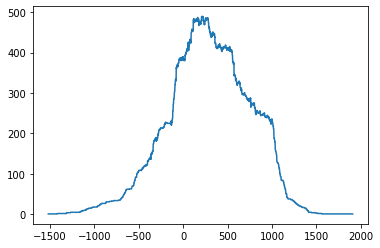

In [49]:
plt.plot(counts_per_bp_dict.keys(), counts_per_bp_dict.values())

In [50]:
chromosome_list = sorted(set(gene_fragment_overlap[0]))

In [51]:
if not os.path.exists(
    os.path.join(
        '/data/pushkare/peak_free_atac',
        'gene_promoter_cell_fragment_overlaps')
):
    os.makedirs(
        os.path.join(
            '/data/pushkare/peak_free_atac',
            'gene_promoter_cell_fragment_overlaps')
        
    )

In [53]:
gene_fragment_dict = {}
for chromosome in chromosome_list:
    chr_overlap_df = gene_fragment_overlap[gene_fragment_overlap[0] == chromosome][[3, 'frag_start_wrt_tss', 'frag_end_wrt_tss', 10]]
    chr_genes_ = set(chr_overlap_df[3])
    chromosome_gene_dict = {}
    for gene_ens_id in tqdm.tqdm(chr_genes_):
        gene_df = chr_overlap_df[chr_overlap_df[3] == gene_ens_id]
        gene_cell_dict = collections.defaultdict(list)
        for cell_barcode, fragment_coord in zip(gene_df[10], list(zip(gene_df['frag_start_wrt_tss'], gene_df['frag_end_wrt_tss']))):
            gene_cell_dict[cell_barcode].append(fragment_coord)
        chromosome_gene_dict[gene_ens_id] = dict(gene_cell_dict)
    if not os.path.exists(
        os.path.join(
            '/data/pushkare/peak_free_atac',
            'gene_promoter_cell_fragment_overlaps')):
        os.makedirs(
            os.path.join(
                '/data/pushkare/peak_free_atac',
                'gene_promoter_cell_fragment_overlaps')
        )
    np.save(
        os.path.join(
            '/data/pushkare/peak_free_atac',
            'gene_promoter_cell_fragment_overlaps',
            'gene_promoter_cell_fragment_overlap_dict_' + chromosome + '.npy'
        ),
        chromosome_gene_dict)

  0%|          | 0/5387 [00:00<?, ?it/s]

  0%|          | 0/2313 [00:00<?, ?it/s]

  0%|          | 0/3336 [00:00<?, ?it/s]

  0%|          | 0/3053 [00:00<?, ?it/s]

  0%|          | 0/1399 [00:00<?, ?it/s]

  0%|          | 0/2272 [00:00<?, ?it/s]

  0%|          | 0/2109 [00:00<?, ?it/s]

  0%|          | 0/2453 [00:00<?, ?it/s]

  0%|          | 0/3014 [00:00<?, ?it/s]

  0%|          | 0/1239 [00:00<?, ?it/s]

  0%|          | 0/2968 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/1455 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/2630 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/3057 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/2419 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### Get gene expression values for cell barcodes, where the respective fragments overlap gene promoter

In [54]:
ensembl_id_to_gene_name_dict = dict(zip(gene_tss['ensembl_id'], gene_tss['gene_name']))

In [48]:
for chromosome in tqdm.tqdm(chromosome_list):
    chromosome_gene_dict = np.load(
        os.path.join(
            '/data/pushkare/peak_free_atac',
            'gene_promoter_cell_fragment_overlaps',
            'gene_promoter_cell_fragment_overlap_dict_' + chromosome + '.npy'
        ),
        allow_pickle=True).item()

    chr_gene_promoters_with_ids = set(chromosome_gene_dict.keys()).intersection(
        set(ensembl_id_to_gene_name_dict.keys())
    )

    chr_gene_names_ = [
        ensembl_id_to_gene_name_dict.get(gene_name_, )
        for gene_name_ in chr_gene_promoters_with_ids
        if ensembl_id_to_gene_name_dict.get(gene_name_, ) in adata.var_names
    ]
    if not os.path.exists(
        os.path.join(
            '/data/pushkare/peak_free_atac',
            'gene_expression_per_cell_barcode',
            chromosome
        )
    ):
        os.makedirs(
            os.path.join(
                '/data/pushkare/peak_free_atac',
                'gene_expression_per_cell_barcode',
                chromosome
            )
        )
    for chr_gene_name_ in chr_gene_names_:
        for key, value in ensembl_id_to_gene_name_dict.items():
            if value == chr_gene_name_:
                ens_id = key
        sc_gene_expression_dict = sc.get.obs_df(
            adata,
            keys=chr_gene_name_
        ).to_dict()
        np.save(
            os.path.join(
                '/data/pushkare/peak_free_atac',
                'gene_expression_per_cell_barcode',
                chromosome,
                '_'.join([chr_gene_name_.replace('/', '_'), ens_id, 'expression_dict', chromosome + '.npy'])
            ),
            {
                cell_bc: expr
                for cell_bc, expr in sc_gene_expression_dict.items()
                if cell_bc in chromosome_gene_dict[ens_id].keys()
            },
            allow_pickle=True
        )

  0%|          | 0/22 [00:00<?, ?it/s]

In [49]:
# chr_expression_df = sc.get.obs_df(
#     adata,
#     keys=[*chr_gene_names_]
# )

In [ ]:
# expression_df.loc[~expression_df.index.isin(set(chromosome_gene_dict['ENSG00000100219'].keys()).intersection(set(expression_df.index))), :]